In [1]:
import altair as alt
import pandas as pd
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [2]:
df_cb_counts = pd.read_csv('https://raw.githubusercontent.com/mattijn/datasets/master/df_cb_counts.csv', index_col=0)
df_dropdp = pd.read_csv('https://raw.githubusercontent.com/mattijn/datasets/master/df_dropdp.csv', index_col=0)
options_list = df_cb_counts.columns.tolist()

In [3]:
variable = options_list[23]

In [4]:
print(variable)

Peat


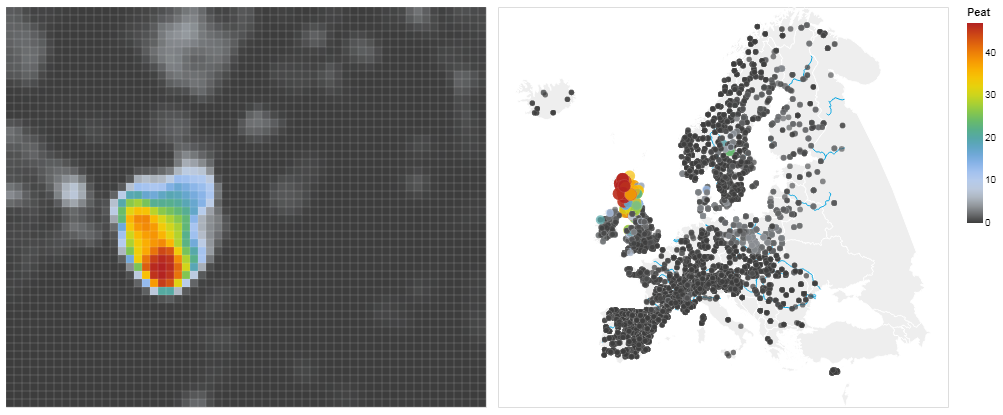

In [5]:
# prepare data   
europe = alt.topo_feature('https://dmws.hkvservices.nl/dataportal/data.asmx/read?database=vega&key=europe', 'europe') 
europe_rivers = alt.Data(url = 'https://dmws.hkvservices.nl/dataportal/data.asmx/read?database=vega&key=europe_rivers', 
                         format = alt.DataFormat(property='features',type='json'))

# set up color scale
scale_color = alt.Scale(range=["#3D3D3D", "#F0F8FF", "cornflowerblue", "mediumseagreen", "#FFEE00", "darkorange", "firebrick"], 
                        zero=False, 
                        nice=False
                        )

binding_vars = alt.binding_select(options=options_list)
select_var = alt.selection_single(bind=binding_vars, name='SELECT_VAR')
brush = alt.selection(type='interval', name='BRUSH')    

# prepare base_matrix
source_matrix = alt.Chart(df_cb_counts)
# prepare matrix chart
matrix = source_matrix.mark_rect().encode(
    x = alt.X('X:O', scale=alt.Scale(rangeStep=8, paddingInner=0.02), axis=None),
    y = alt.Y('Y:O', scale=alt.Scale(rangeStep=8, paddingInner=0.02), axis=None),
    opacity = alt.condition(brush, alt.value(1),  alt.value(0.2)),
    color = alt.Color('{}:Q'.format(variable), scale=scale_color)                    
).add_selection(
    brush
)

map_base = alt.Chart(europe).mark_geoshape(
    stroke='white'
).encode(
    color=alt.value('#eee'),
).properties(
    width=450,
    height=400
)

map_rivers = alt.Chart(europe_rivers).mark_geoshape(
    stroke='#00A4E2'
)

map_dynamic = alt.Chart(df_dropdp).mark_circle(
    stroke='white',
    strokeWidth=0.1
).encode(
    longitude='lon:Q',
    latitude='lat:Q',
    size=alt.Size('{}:Q'.format(variable), sort= "ascending", scale=alt.Scale(range=[30, 160]), legend=None),
    color = alt.Color('{}:Q'.format(variable), sort= "ascending", scale=scale_color)
).transform_lookup(
    lookup = 'som_key',
    from_ = alt.LookupData(df_cb_counts, 'XY'),
    as_ = 'geo'
).transform_calculate(
    "X", "datum.geo.X"
).transform_calculate(
    "Y", "datum.geo.Y"
).transform_calculate(
    "{}".format(variable), "datum.geo.{}".format(variable)
).transform_filter(
    brush 
)

matrix | (map_base + map_rivers + map_dynamic)